In [14]:
from astropy.io import ascii, fits
import numpy as np
import os
import glob
from astropy.time import Time
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture,CircularAnnulus,aperture_photometry
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
import matplotlib as mpl


#####INPUT#########################    
path = os.path.join('C2023A3_r') 
FILE = glob.glob(os.path.join(path,'pSQ*.fits'))
FILE = sorted(FILE)

Ann = 300 #[pix]
Dan = 200 #[pix]
Apersize = 4 # Aperture size = Apersize*FWHM

for n,file in enumerate(FILE):
    hdul = fits.open(file)[0]
    header = hdul.header
    data =hdul.data
    print(file.split('/')[-1], header['OBJECT'],header['HWPANG'])
    if (n+1)%8==0:
        print()
#########################    

pSQ20241016_000036_Cam1.fits C2023A3_r 0.0
pSQ20241016_000036_Cam2.fits C2023A3_r 0.0
pSQ20241016_000036_Cam3.fits C2023A3_r 0.0
pSQ20241016_000036_Cam4.fits C2023A3_r 0.0
pSQ20241016_000037_Cam1.fits C2023A3_r 45.0
pSQ20241016_000037_Cam2.fits C2023A3_r 45.0
pSQ20241016_000037_Cam3.fits C2023A3_r 45.0
pSQ20241016_000037_Cam4.fits C2023A3_r 45.0

pSQ20241016_000038_Cam1.fits C2023A3_r 0.0
pSQ20241016_000038_Cam2.fits C2023A3_r 0.0
pSQ20241016_000038_Cam3.fits C2023A3_r 0.0
pSQ20241016_000038_Cam4.fits C2023A3_r 0.0
pSQ20241016_000039_Cam1.fits C2023A3_r 45.0
pSQ20241016_000039_Cam2.fits C2023A3_r 45.0
pSQ20241016_000039_Cam3.fits C2023A3_r 45.0
pSQ20241016_000039_Cam4.fits C2023A3_r 45.0



In [15]:
def skyvalue(data,y0,x0,r_in,r_out):
    # Determine sky and std
    y_in = int(y0-r_out)
    y_out = int(y0+r_out)
    x_in = int(x0-r_out)
    x_out = int(x0+r_out)

    sky_deriving_area = data[y_in:y_out, x_in:x_out]
    mask = np.zeros(np.shape(sky_deriving_area))+1
    for yi in range(len(sky_deriving_area)):
        for xi in range(len(sky_deriving_area[0])):
            position = (xi - r_out)**2 + (yi-r_out)**2
            if position < (r_out)**2 and position > r_in**2 and xi > int(len(mask[0])/2):
                mask[yi, xi] = 0
    mask = mask.astype(bool)
    Sky_region = np.ma.masked_array(sky_deriving_area, mask)
    std = np.ma.std(Sky_region)
    sky = np.ma.median(Sky_region)
    npix = np.shape(sky_deriving_area)[0]*np.shape(sky_deriving_area)[1] - np.sum(mask)
    return(sky, std, npix)
def crop(data,row,col,size):
    row_str = int(row-size)
    row_end = int(row+size)
    col_str = int(col-size)
    col_end = int(col+size)
    data_cr = data[row_str:row_end,col_str:col_end]
    return data_cr
def circle(x,y,r):
    theta = np.linspace(0, 2*np.pi, 100)
    x1 = r*np.cos(theta)+y
    x2 = r*np.sin(theta)+x
    return(x2.tolist(),x1.tolist())

C2023A3_r/pSQ20241016_000036_Cam1.fits
C2023A3_r/pSQ20241016_000036_Cam2.fits
C2023A3_r/pSQ20241016_000036_Cam3.fits
C2023A3_r/pSQ20241016_000036_Cam4.fits
C2023A3_r/pSQ20241016_000037_Cam1.fits
C2023A3_r/pSQ20241016_000037_Cam2.fits
C2023A3_r/pSQ20241016_000037_Cam3.fits
C2023A3_r/pSQ20241016_000037_Cam4.fits
C2023A3_r/pSQ20241016_000038_Cam1.fits
C2023A3_r/pSQ20241016_000038_Cam2.fits
C2023A3_r/pSQ20241016_000038_Cam3.fits
C2023A3_r/pSQ20241016_000038_Cam4.fits
C2023A3_r/pSQ20241016_000039_Cam1.fits
C2023A3_r/pSQ20241016_000039_Cam2.fits
C2023A3_r/pSQ20241016_000039_Cam3.fits
C2023A3_r/pSQ20241016_000039_Cam4.fits


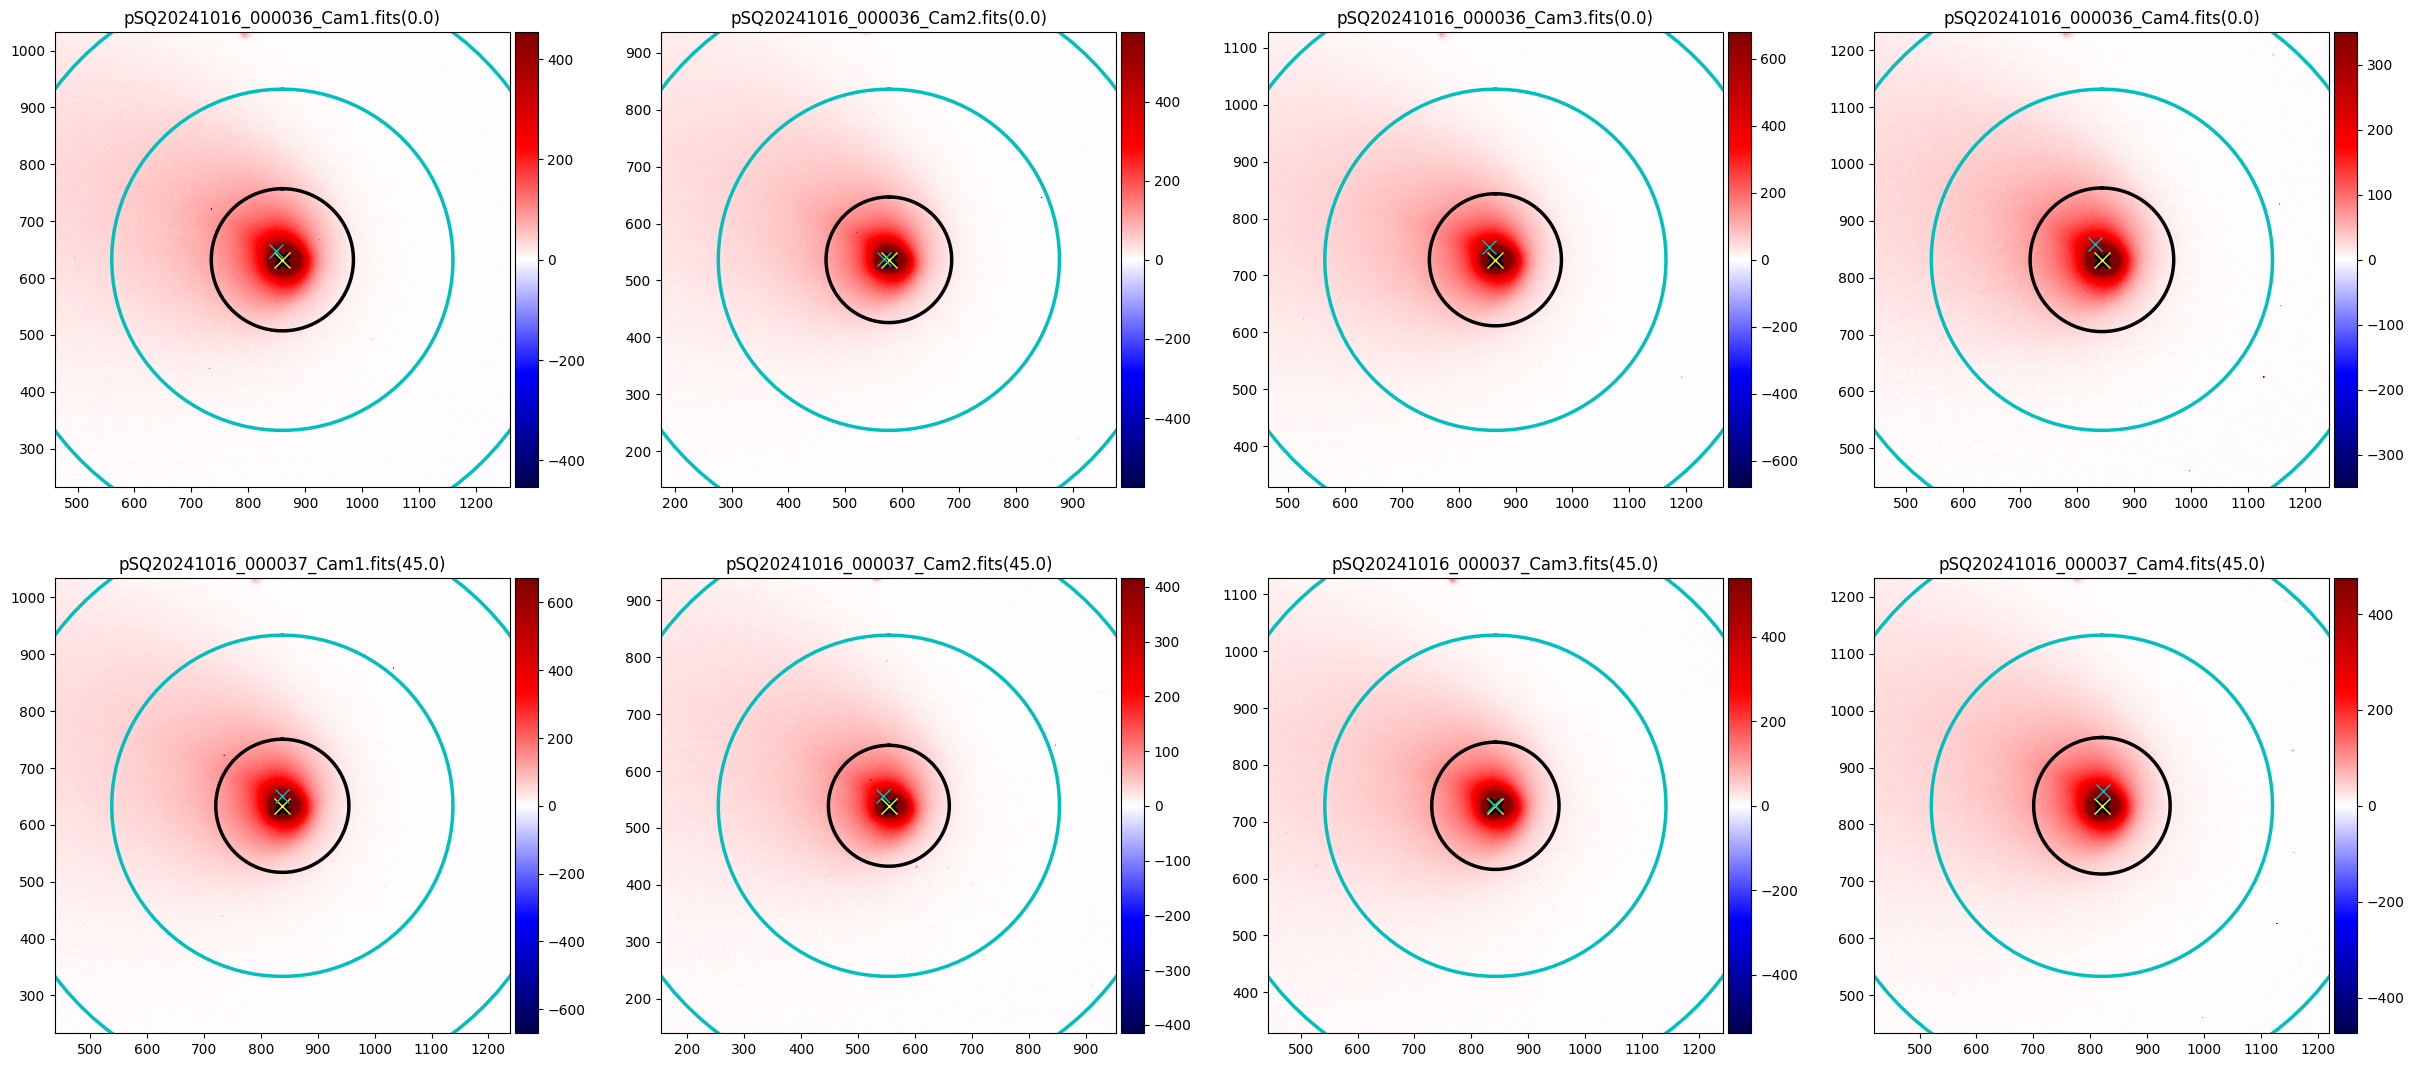

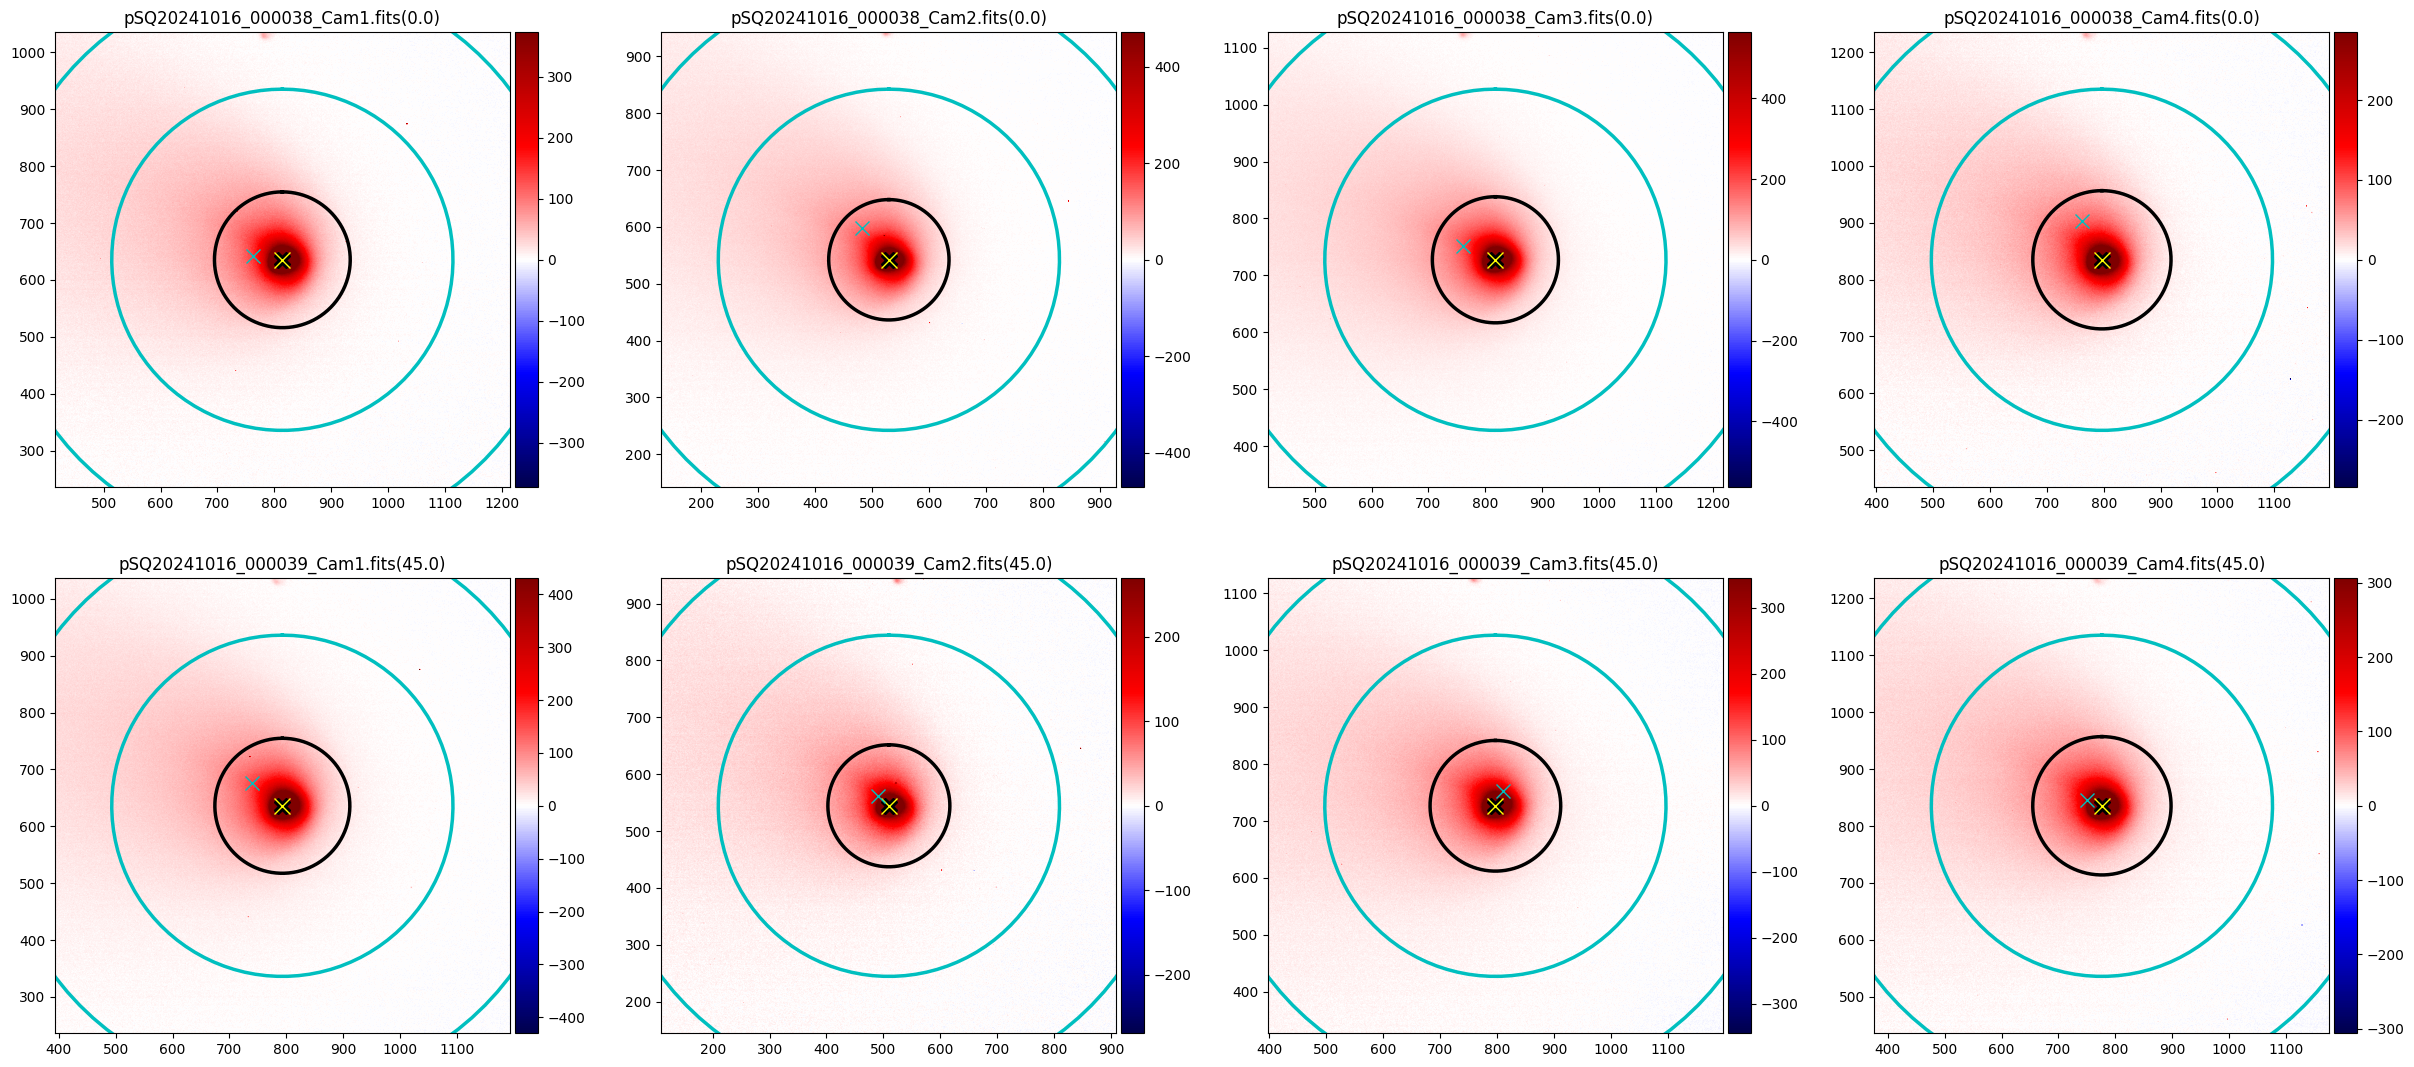

In [71]:
#Apterture Photometry

Photo_Log = pd.DataFrame({})
order = np.arange(0,len(FILE),8)
for n_,z in enumerate(order):
    SET = [FILE[z],FILE[z+1], FILE[z+2], FILE[z+3],
           FILE[z+4],FILE[z+5], FILE[z+6], FILE[z+7]]
    JD_av = []
    EXP_av = []
    fig,ax = plt.subplots(2,4,figsize=(30,13))
    for i in range(0,8):
        File_ang = SET[i]  #Bring the fits file
        print(File_ang)
        hdul = fits.open(File_ang)
        header = hdul[0].header 
        data = hdul[0].data
        gain = header['GAIN']
        Filter = header['FILTER']
        RN = 1.26 
        
        
        #Fitting 2D Gaussian to the target
        center = pd.read_csv(File_ang+'.csv')
        x_init,y_init = center['XCENTER'].values[0],center['YCENTER'].values[0]-10
        #Find the FWHM of the object

        crop_size = 300
        crop_image = crop(data,y_init,x_init,crop_size)
        sky,sky_std,area = skyvalue(crop_image,crop_size,crop_size,
                                    crop_size/2,crop_size)
        crop_image_sub = crop_image - sky
        
        ##Fitting Gaussian2D
        g_init = Gaussian2D(amplitude=crop_image_sub[crop_size,crop_size],
                                x_mean = crop_size,y_mean=crop_size,
                                theta = 0)
        y, x = np.mgrid[:len(crop_image), :len(crop_image[0])]
        fitter = LevMarLSQFitter()
        fitted = fitter(g_init, x, y, crop_image_sub)
        center_x = fitted.x_mean.value
        center_y = fitted.y_mean.value
            
        ##Re-Fitting Gaussian2D
        re_g_init = Gaussian2D(amplitude=fitted.amplitude.value,
                               x_mean = center_x,y_mean=center_y,
                               theta = 0,                                   
                               x_stddev = fitted.x_stddev.value,
                               y_stddev = fitted.y_stddev.value)
        fitter = LevMarLSQFitter()
        fitted = fitter(re_g_init, x, y,crop_image_sub)
        center_x = fitted.x_mean.value
        center_y = fitted.y_mean.value
        fwhm = max(fitted.x_fwhm,fitted.y_fwhm)
        x_cen = center_x + (x_init-crop_size) 
        y_cen = center_y + (y_init-crop_size) 
            
            
        #Deriving the sky
        sky,sky_std,sky_npix = skyvalue(data,y_cen,x_cen,
                                        Ann,Ann+Dan) 
        #Aperture photometry
        aperture_radius = Apersize*1/2*fwhm
        aperture_ = CircularAperture([x_cen,y_cen],aperture_radius)
        Flux= aperture_photometry(data-sky, aperture_)['aperture_sum'][0]
        Flux_e, sky_e, sky_std_e = gain*Flux, gain*sky, gain*sky_std #[ADU]--> [e]
        err_Flux = np.sqrt(Flux_e + np.pi*aperture_radius**2*(sky_e + (RN)**2))
        
        
        lim=0.5*Flux/aperture_radius**2
        fontsize=18
        figsize=400
        im = ax[i//4,i%4].imshow(data - sky,
                                 vmin=-2*lim,vmax=2*lim,cmap='seismic')
        xi,yi = circle(x_cen,y_cen,aperture_radius)
        ax[i//4,i%4].plot(xi,yi,color='k',lw=2.5,zorder=11)
        xi,yi = circle(x_cen,y_cen,Ann)
        ax[i//4,i%4].plot(xi,yi ,color='c',lw=2.5)
        xi,yi = circle(x_cen,y_cen,Ann+Dan)
        ax[i//4,i%4].plot(xi,yi ,color='c',lw=2.5)
        ax[i//4,i%4].plot(x_cen,y_cen,marker='X',ls='',color='k',ms=12)
        ax[i//4,i%4].plot(x_cen,y_cen,marker='x',ls='',color='yellow',ms=12)
        ax[i//4,i%4].plot(x_init, y_init, marker='x',ls='',color='c', ms=10)
        ax[i//4,i%4].set_xlim(x_cen-figsize,x_cen+figsize)
        ax[i//4,i%4].set_ylim(y_cen-figsize,y_cen+figsize)
        ax[i//4,i%4].set_title(File_ang.split('/')[-1]+'({0:.1f})'.format(float(header['HWPANG'])),
                               fontsize=12)
        divider = make_axes_locatable(ax[i//4,i%4])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im,cax=cax) 
        JD = Time(header['DATE-OBS']+'T'+header['UT'], format='isot').jd    
        Photo_Log = pd.concat([Photo_Log,
                               pd.DataFrame({
                                   'filename':[File_ang.split('/')[-1]],
                                   'Object':[header['OBJECT']],
                                   'DATE':[header['DATE-OBS']],
                                   'JD':[JD],
                                   'UT':[header['UT']],
                                   'HWPANG':[float(header['HWPANG'])],
                                   'FILTER':[Filter],
                                   'EXPTIME':[header['EXPTIME']],
                                   'Cam':[i%4+1], #ID of cam (e.g., Cam1, Cam2, Cam3, Cam4)==0:
                                   'FWHM [pix]': [fwhm],
                                   'Aperture size [pix]':[aperture_radius],
                                   'Flux [e]':[Flux_e],
                                   'eFlux [e]':[err_Flux],
                                   'Sky [e]':[sky_e],
                                   'std_Sky [e]': [sky_std_e],
                                   'Ann [pix]':[Ann],
                                   'Dan [pix]':[Dan],
                                   'Cen (y,x)':[(int(y_cen),int(x_cen))]})])
#         plt.show()
    Phot_name = ['filename', 'Object','DATE','UT','JD', 'EXPTIME','Cam',
                 'HWPANG','FILTER','FWHM [pix]','Aperture size [pix]',
                 'Flux [e]','eFlux [e]','Sky [e]','std_Sky [e]','Ann [pix]',
                 'Dan [pix]','Cen (y,x)']
    Photo_Log = Photo_Log.reindex(columns=Phot_name)
    Photo_Log = Photo_Log.round({'EXPTIME':1,'HWPANG':1,
                                 'FWHM [pix]':1,'Aperture size [pix]':1,
                                 'Flux [e]':1,'eFlux [e]':1,'Sky [e]':1,'std_Sky [e]':1})
    Filename = os.path.join(path,'result','Photo_{0}.{1}.csv'.format(header['OBJECT'],header['DATE-OBS']))
    if os.path.exists(os.path.join(path,'result'))==False:
        os.mkdir(os.path.join(path,'result'))    
    Filename = Filename.replace('-','_')
    Photo_Log.to_csv(Filename, index=False)
        

In [ ]:
import numpy as np
import pandas as pd

#Calibration values 
q_inst, dq_inst = 0.28/100, 0.16/100
u_inst, du_inst = 0.45/100, 0.26/100
off, doff = np.deg2rad(-8.85), np.deg2rad(0.2)

#camera mapping
cam_map = {'Ocam1': 4, 'Ocam2': 3, 'Ocam3': 1, 'Ocam4': 2}
results = []

# Stockes parameters calculation 
for i in range(int(len(Photo_Log)/8)):
    sub = Photo_Log.iloc[i*8:(i+1)*8]

    def f(cam, hwp):
        row = sub[(sub['Cam']==cam)&(sub['HWPANG']==hwp)]
        return row['Flux [e]'].values[0], row['eFlux [e]'].values[0]

    O1_0, eO1_0 = f(cam_map['Ocam1'],0)
    O2_0, eO2_0 = f(cam_map['Ocam2'],0)
    O3_0, eO3_0 = f(cam_map['Ocam3'],0)
    O4_0, eO4_0 = f(cam_map['Ocam4'],0)
    O1_45, eO1_45 = f(cam_map['Ocam1'],45)
    O2_45, eO2_45 = f(cam_map['Ocam2'],45)
    O3_45, eO3_45 = f(cam_map['Ocam3'],45)
    O4_45, eO4_45 = f(cam_map['Ocam4'],45)

    # --- q, u ---
    a1 = np.sqrt((O2_0/O1_0)/(O2_45/O1_45))
    a2 = np.sqrt((O4_0/O3_0)/(O4_45/O3_45))
    q = (1-a1)/(1+a1)
    u = (1-a2)/(1+a2)

    dq_da1 = -2/(1+a1)**2
    du_da2 = -2/(1+a2)**2
    da1 = a1*0.5*np.sqrt((eO2_0/O2_0)**2+(eO1_0/O1_0)**2+(eO2_45/O2_45)**2+(eO1_45/O1_45)**2)
    da2 = a2*0.5*np.sqrt((eO4_0/O4_0)**2+(eO3_0/O3_0)**2+(eO4_45/O4_45)**2+(eO3_45/O3_45)**2)
    dq = abs(dq_da1)*da1
    du = abs(du_da2)*da2

    # Instrumental polarization correction 
    q1 = q - q_inst
    u1 = u - u_inst
    dq1 = np.sqrt(dq**2 + dq_inst**2)
    du1 = np.sqrt(du**2 + du_inst**2)

    # Transformation to the celestial coordinate
    c2, s2 = np.cos(2*off), np.sin(2*off)
    q2 = q1*c2 + u1*s2
    u2 = -q1*s2 + u1*c2

    dq2 = np.sqrt((c2*dq1)**2 + (s2*du1)**2)
    du2 = np.sqrt((s2*dq1)**2 + (c2*du1)**2)

    #Stokes parameters -> Polarization degree and angle
    P = np.sqrt(q2**2 + u2**2)
    dP = np.sqrt((q2*dq2)**2 + (u2*du2)**2) / P
    theta = 0.5*np.degrees(np.arctan2(u2,q2))
    if theta < 0: theta += 180
    dtheta = 0.5*(180/np.pi)*np.sqrt((u2*dq2)**2 + (q2*du2)**2)/(q2**2+u2**2)

    results.append({
        'Set': i+1,
        'q (%)': round(q2*100, 2), 'dq (%)': round(dq2*100, 2),
        'u (%)': round(u2*100, 2), 'du (%)': round(du2*100, 2),
        'P (%)': round(P*100, 2),  'dP (%)': round(dP*100, 2),
        'θ (deg)': round(theta, 2), 'dθ (deg)': round(dtheta, 2)
    })

df_results = pd.DataFrame(results)
print(df_results)


#Average calculation
mean_P = df_results['P (%)'].mean()
mean_theta = df_results['θ (deg)'].mean()
dP_avg = np.sqrt(np.sum(df_results['dP (%)']**2)) / len(df_results)
dtheta_avg = np.sqrt(np.sum(df_results['dθ (deg)']**2)) / len(df_results)

#RESULT~~~~~~~~~!!!!
print(f"\nAverage P: {mean_P:.2f} ± {dP_avg:.2f} %")
print(f"Average theta: {mean_theta:.2f} ± {dtheta_avg:.2f} deg")

   Set  q (%)  dq (%)  u (%)  du (%)  P (%)  dP (%)  θ (deg)  dθ (deg)
0    1  -7.18    0.21 -19.99    0.28  21.24    0.27   125.12      0.30
1    2  -6.82    0.23 -19.91    0.30  21.05    0.29   125.54      0.32

Average P: 21.14 ± 0.20 %
Average theta: 125.33 ± 0.22 deg
